In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from models import BiLSTM
from ANFISpy import LSTMANFIS

## Pre-Processing

Importing and converting data.

In [2]:
df = pd.read_csv('brazil_covid19_macro.csv')
cases = df['cases'].values
dates = df['date'].values
days = np.array([i for i in range(cases.shape[0])], dtype='float32')

tick_indices = [i for i, d in enumerate(dates) if d.endswith('-01')]
tick_labels = [dates[i] for i in tick_indices]

Processing the data.

In [3]:
total_len = len(cases)  
train_size = int(0.8 * total_len)
val_size = int(0.1 * total_len)
test_size = total_len - train_size - val_size

cases_train = cases[:train_size + val_size]
cases_test = cases[train_size + val_size:]

days_train = days[:train_size + val_size]
days_test = days[train_size + val_size:]

norm_min, norm_max = cases_train.min(), cases_train.max()

cases_train = (cases_train - norm_min) / (norm_max - norm_min)
cases_test  = (cases_test - norm_min) / (norm_max - norm_min)

def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(len(data) - seq_length):
        x.append(data[i:i + seq_length])     
        y.append(data[i + 1 : i + seq_length + 1])  
    x = torch.FloatTensor(np.array(x)).unsqueeze(-1) 
    y = torch.FloatTensor(np.array(y)).unsqueeze(-1)
    return x, y

seq_len_bilstm = 15

x_train, y_train = create_sequences(cases_train, seq_len_bilstm)
x_test,  y_test  = create_sequences(cases_test, seq_len_bilstm)

aligned_days_train = days_train[seq_len_bilstm:]
aligned_days_test  = days_test[seq_len_bilstm:]

train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)

Instantiating BiLSTM.

In [4]:
bilstm = BiLSTM(
    h=119,
    activation=nn.Identity(),  
)

params_bilstm = sum(p.numel() for p in bilstm.parameters())
print(f'Number of parameters: {params_bilstm}')

Number of parameters: 116264


Training the model.

In [5]:
try:
    best_model_path = 'best_models/bilstm.pth'  
    checkpoint = torch.load(best_model_path, weights_only=True)
    bilstm.load_state_dict(checkpoint['model_state_dict'])
    print('Loaded.')

except:
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(bilstm.parameters(), lr=0.000333)

    epochs = 1000
    best_train_loss = float('inf')
    best_model_path = 'best_models/bilstm.pth'

    for epoch in range(epochs):
        bilstm.train()
        epoch_loss_train = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = bilstm(X_batch)[0]
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss_train += loss.item() * X_batch.size(0) 

        epoch_loss_train /= len(train_loader.dataset)

        if epoch_loss_train < best_train_loss:
                best_train_loss = epoch_loss_train
                torch.save({
                    'model_state_dict': bilstm.state_dict(),
                }, best_model_path)

        if epoch % 50 == 0:
            print(f'Epoch {epoch} | Train Loss: {best_train_loss:.8f}')

    checkpoint = torch.load(best_model_path, weights_only=True)
    bilstm.load_state_dict(checkpoint['model_state_dict'])

Loaded.


Plotting training data predictions.

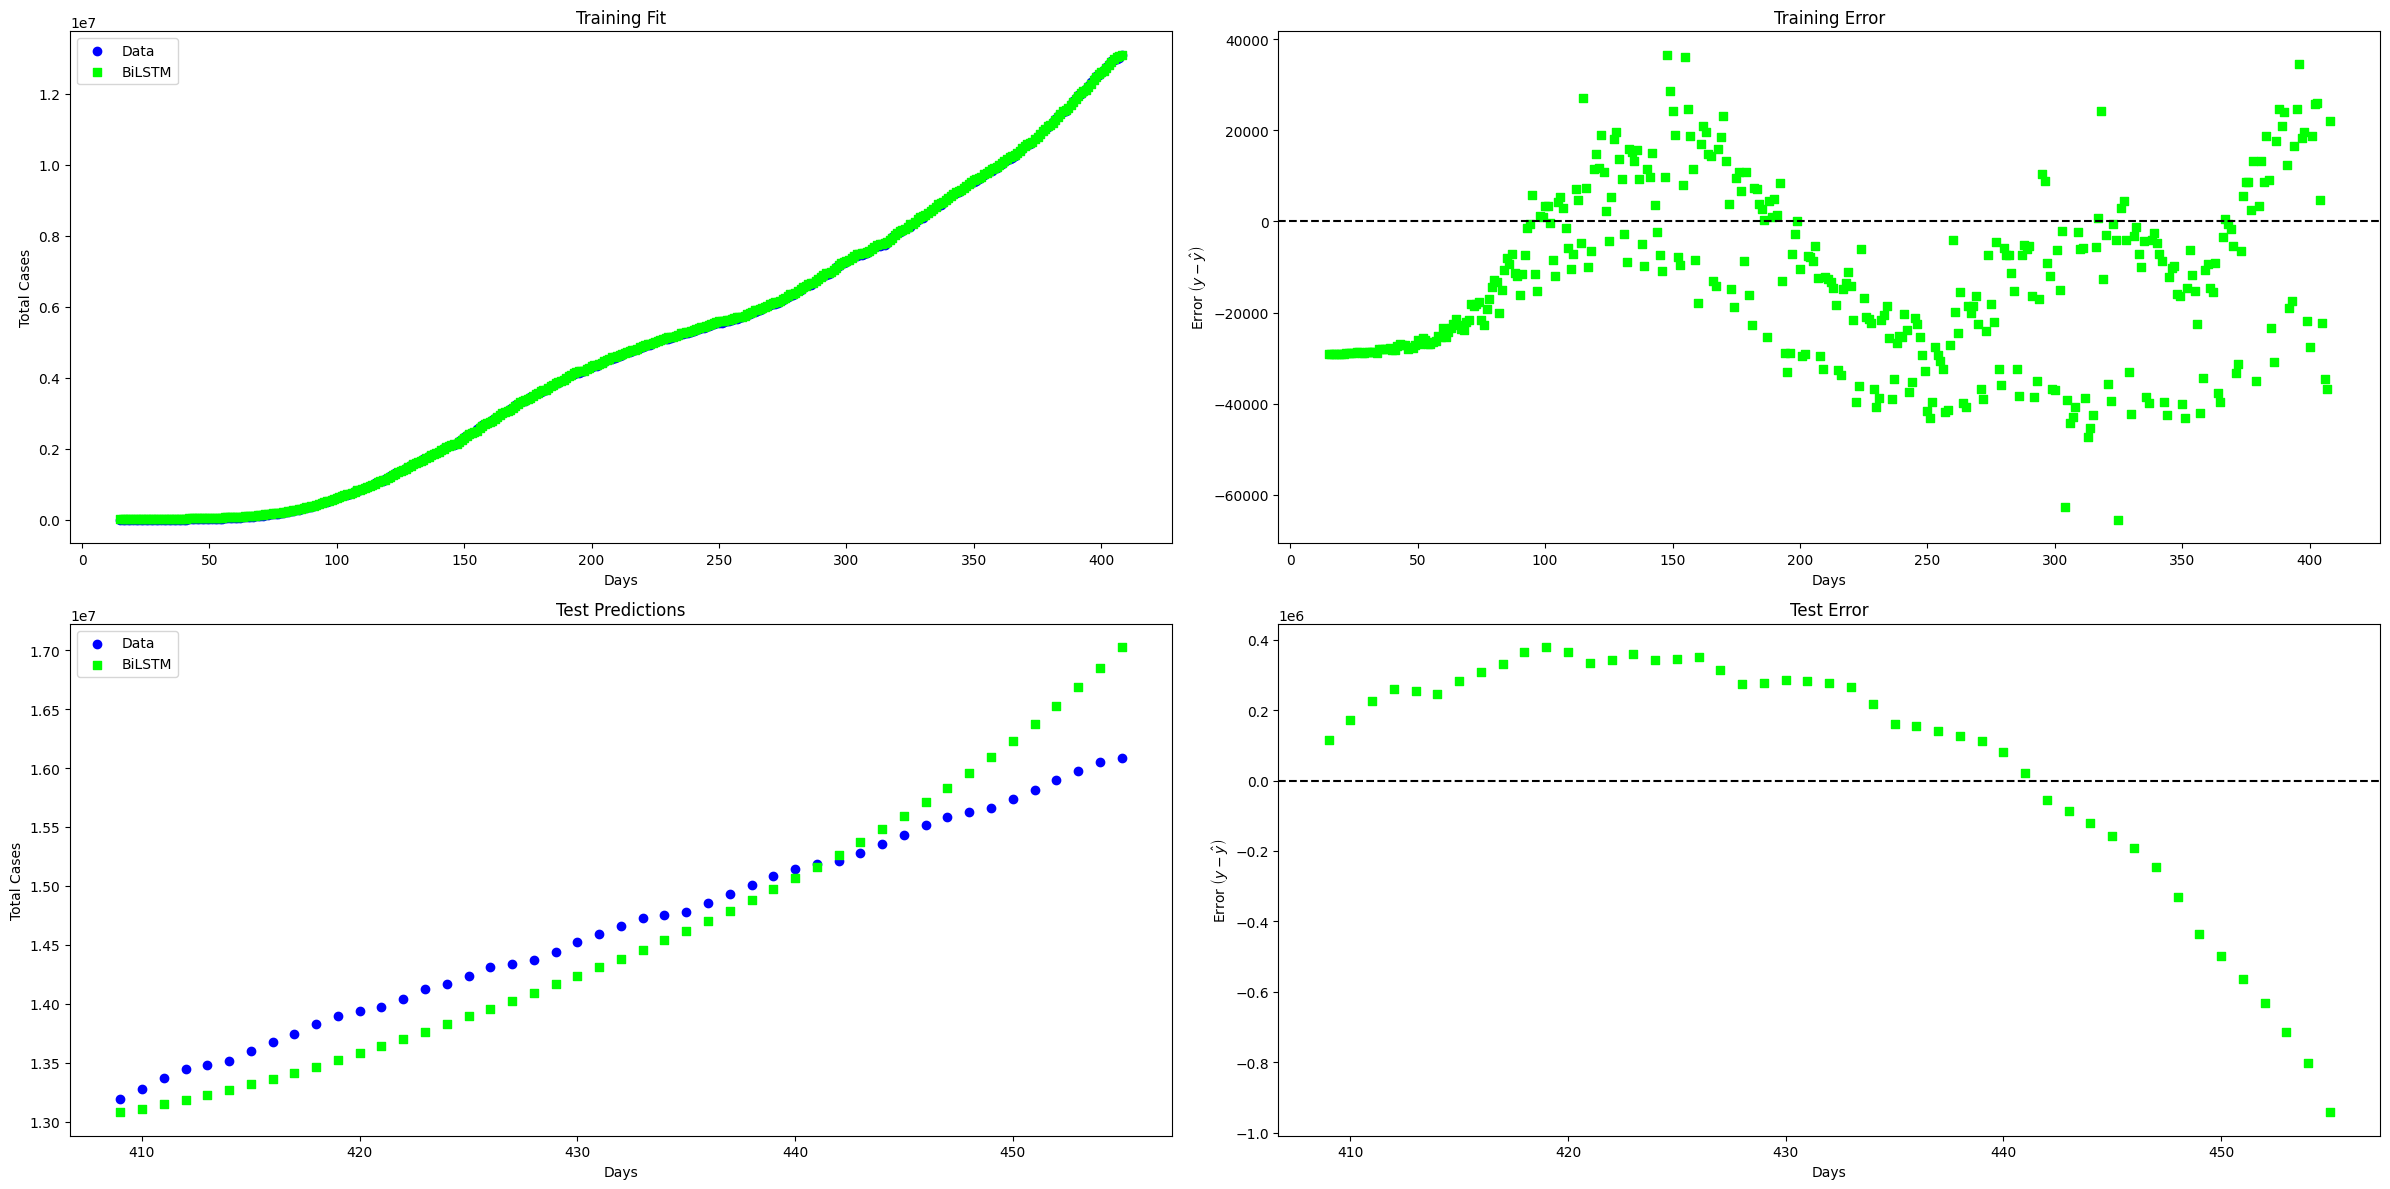

In [6]:
bilstm.eval()
test_predictions_bilstm = []

with torch.no_grad():
    train_predictions_bilstm = bilstm(x_train)[0][:, -1, :].numpy().flatten()
    
    last_data = x_train[-1:]
    h, c = None, None
    
    for _ in range(len(days_test)):
        (pred, (h_new, c_new)) = bilstm(last_data, (h, c) if h is not None else None)
        test_predictions_bilstm.append(pred[:, -1:, 0].item())
        last_data = torch.cat([last_data[:, 1:, :], pred[:, -1:, :]], dim=1)
        h, c = h_new, c_new

train_predictions_bilstm = train_predictions_bilstm * (norm_max - norm_min) + norm_min
test_predictions_bilstm = np.array(test_predictions_bilstm) * (norm_max - norm_min) + norm_min

cases_train_denorm = cases_train[seq_len_bilstm:] * (norm_max - norm_min) + norm_min
cases_test_denorm = cases_test * (norm_max - norm_min) + norm_min

fig, ax = plt.subplots(2, 2, figsize=(24, 12))

ax[0, 0].scatter(aligned_days_train, cases_train_denorm, label='Data', c='blue')
ax[0, 0].scatter(aligned_days_train, train_predictions_bilstm, label='BiLSTM', marker='s', c='lime')
ax[0, 0].set_title("Training Fit")
ax[0, 0].set_xlabel("Days")
ax[0, 0].set_ylabel("Total Cases")
ax[0, 0].legend()

ax[0, 1].scatter(aligned_days_train, cases_train_denorm - train_predictions_bilstm, color='lime', marker='s')
ax[0, 1].axhline(0, color='black', linestyle='--')
ax[0, 1].set_title("Training Error")
ax[0, 1].set_xlabel("Days")
ax[0, 1].set_ylabel(r"Error $\left(y - \hat{y}\right)$")

ax[1, 0].scatter(days_test, cases_test_denorm, label='Data', c='blue')
ax[1, 0].scatter(days_test, test_predictions_bilstm, label='BiLSTM', marker='s', c='lime')
ax[1, 0].set_title("Test Predictions")
ax[1, 0].set_xlabel("Days")
ax[1, 0].set_ylabel("Total Cases")
ax[1, 0].legend()

ax[1, 1].scatter(days_test, cases_test_denorm - test_predictions_bilstm, color='lime', marker='s')
ax[1, 1].axhline(0, color='black', linestyle='--')
ax[1, 1].set_title("Test Error")
ax[1, 1].set_xlabel("Days")
ax[1, 1].set_ylabel(r"Error $\left(y - \hat{y}\right)$")

plt.tight_layout()
plt.show()

## BiLSTM-ANFIS

Instantiating model.

In [7]:
n_vars = 1
seq_len_bilstmanfis = 12
mf_names = [['L', 'ML', 'M', 'MH', 'H']] 

variables = {
    'inputs': {
        'n_sets': [5],
        'uod': n_vars * [(0, 1.5)],
        'var_names': ['Cases'],
        'mf_names': n_vars * mf_names,
    },
    'output': {
        'var_names': 'New Cases',
        'n_classes': 1,
    },
}

bilstmanfis = LSTMANFIS(
    variables, 
    'bell', 
    seq_len_bilstmanfis,
    output_activation=nn.Identity(), 
    and_operator=torch.min,
    bidirectional=True
)

params_bilstmanfis = 0
for p in list(bilstmanfis.parameters()):
    params_bilstmanfis += p.flatten().shape[0]
    
print(f'Number of parameters: {params_bilstmanfis}')

Number of parameters: 505


Separating data.

In [8]:
total_len = len(cases)  
train_size = int(0.8 * total_len)
val_size = int(0.1 * total_len)
test_size = total_len - train_size - val_size

cases_train = cases[:train_size + val_size]
cases_test = cases[train_size + val_size:]

days_train = days[:train_size + val_size]
days_test = days[train_size + val_size:]

norm_min, norm_max = cases_train.min(), cases_train.max()

cases_train = (cases_train - norm_min) / (norm_max - norm_min)
cases_test  = (cases_test - norm_min) / (norm_max - norm_min)

def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(len(data) - seq_length):
        x.append(data[i:i + seq_length])     
        y.append(data[i + 1 : i + seq_length + 1])  
    x = torch.FloatTensor(np.array(x)).unsqueeze(-1) 
    y = torch.FloatTensor(np.array(y)).unsqueeze(-1)
    return x, y

x_train, y_train = create_sequences(cases_train, seq_len_bilstmanfis)
x_test,  y_test  = create_sequences(cases_test, seq_len_bilstmanfis)

aligned_days_train = days_train[seq_len_bilstmanfis:]
aligned_days_test  = days_test[seq_len_bilstmanfis:]

train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)

Training.

In [9]:
try:
    best_model_path = 'best_models/bilstmanfis.pth'  
    checkpoint = torch.load(best_model_path, weights_only=True, map_location=torch.device('cpu'))
    bilstmanfis.load_state_dict(checkpoint['model_state_dict'])
    print('Loaded.')

except:
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(bilstmanfis.parameters(), lr=0.005749)
    
    epochs = 1000
    best_train_loss = float('inf')
    best_model_path = 'best_models/bilstmanfis.pth'
    
    for epoch in range(epochs):
        bilstmanfis.train()
        epoch_loss_train = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = bilstmanfis(X_batch)[0]
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss_train += loss.item() * X_batch.size(0) 
    
        epoch_loss_train /= len(train_loader.dataset)
    
        if epoch_loss_train < best_train_loss:
            best_train_loss = epoch_loss_train
            torch.save({
                'model_state_dict': bilstmanfis.state_dict(),
            }, best_model_path)
        
        if epoch % 50 == 0:
            print(f'Epoch {epoch} | Train Loss: {best_train_loss:.8f}')
    
    checkpoint = torch.load(best_model_path, weights_only=True)
    bilstmanfis.load_state_dict(checkpoint['model_state_dict'])

Loaded.


Plotting.

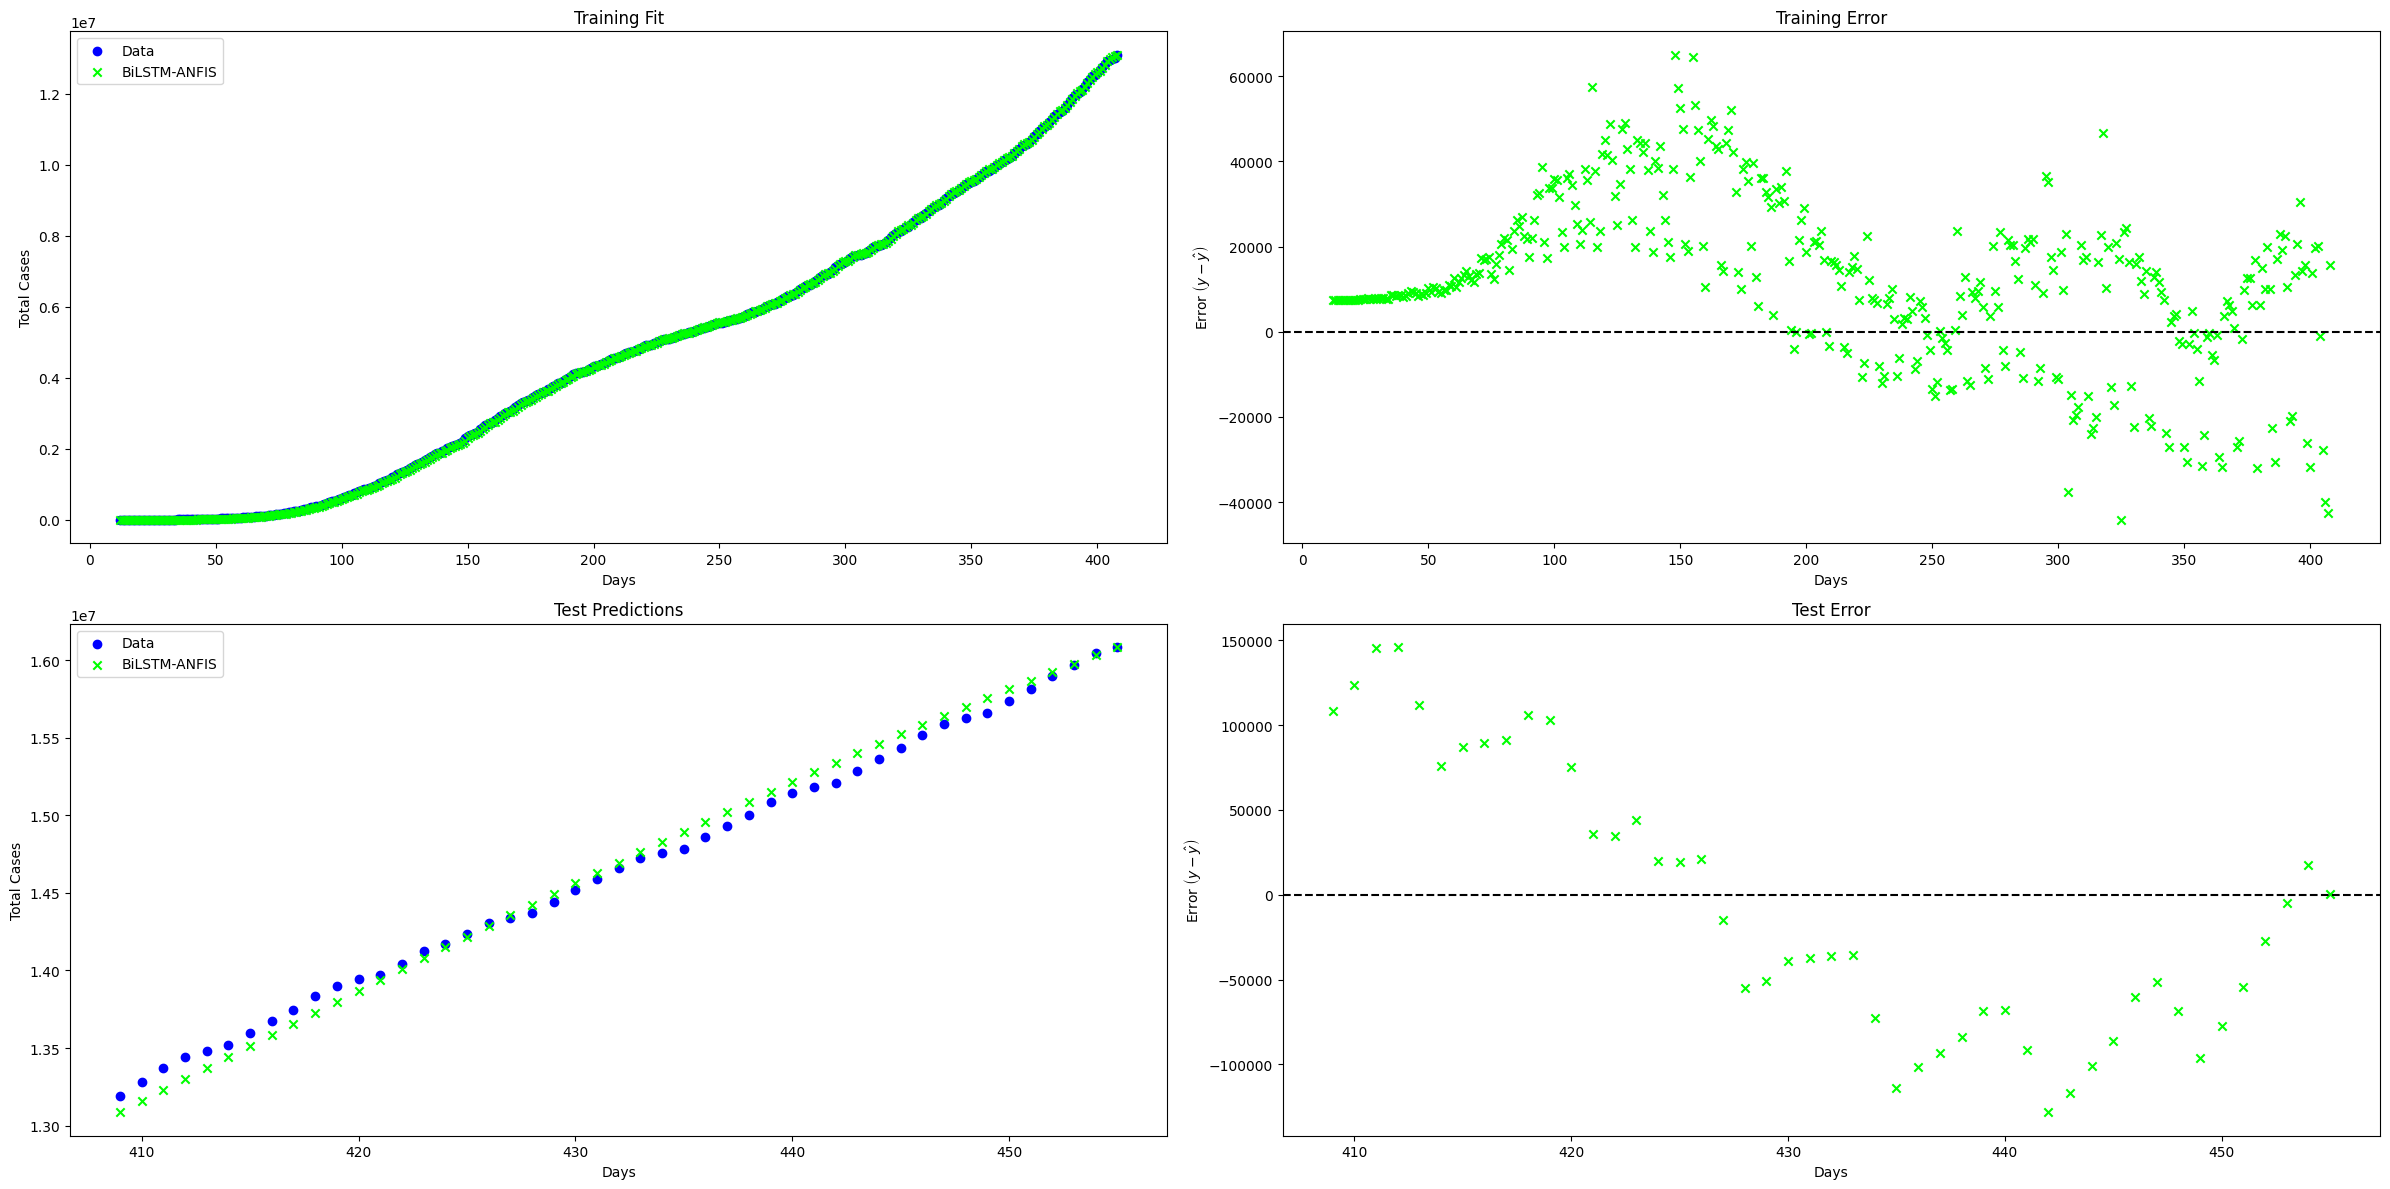

In [10]:
bilstmanfis.eval()
test_predictions_bilstmanfis = []

with torch.no_grad():
    train_predictions_bilstmanfis = bilstmanfis(x_train)[0][:, -1, :].numpy().flatten()
    
    last_data = x_train[-1:]
    hc = None, None
    
    for _ in range(len(days_test)):  
        pred, hcnew = bilstmanfis(last_data, hc)  
        test_predictions_bilstmanfis.append(pred[:, -1:, :].item())
        last_data = torch.cat([last_data[:, 1:, :], pred[:, -1:, :]], dim=1)  
        hc = hcnew
        
train_predictions_bilstmanfis = train_predictions_bilstmanfis * (norm_max - norm_min) + norm_min
test_predictions_bilstmanfis = np.array(test_predictions_bilstmanfis) * (norm_max - norm_min) + norm_min

cases_train_denorm = cases_train[seq_len_bilstmanfis:] * (norm_max - norm_min) + norm_min
cases_test_denorm = cases_test * (norm_max - norm_min) + norm_min

fig, ax = plt.subplots(2, 2, figsize=(24, 12))

ax[0, 0].scatter(days_train[seq_len_bilstmanfis:], cases_train_denorm, label='Data', c='blue')
ax[0, 0].scatter(days_train[seq_len_bilstmanfis:], train_predictions_bilstmanfis, label='BiLSTM-ANFIS', marker='x', c='lime')
ax[0, 0].set_title("Training Fit")
ax[0, 0].set_xlabel("Days")
ax[0, 0].set_ylabel("Total Cases")
ax[0, 0].legend()

ax[0, 1].scatter(days_train[seq_len_bilstmanfis:], cases_train_denorm - train_predictions_bilstmanfis, color='lime', marker='x')
ax[0, 1].axhline(0, color='black', linestyle='--')
ax[0, 1].set_title("Training Error")
ax[0, 1].set_xlabel("Days")
ax[0, 1].set_ylabel(r"Error $\left(y - \hat{y}\right)$")

ax[1, 0].scatter(days_test, cases_test_denorm, label='Data', c='blue')
ax[1, 0].scatter(days_test, test_predictions_bilstmanfis, label='BiLSTM-ANFIS', marker='x', c='lime')
ax[1, 0].set_title("Test Predictions")
ax[1, 0].set_xlabel("Days")
ax[1, 0].set_ylabel("Total Cases")
ax[1, 0].legend()

ax[1, 1].scatter(days_test, cases_test_denorm - test_predictions_bilstmanfis, color='lime', marker='x')
ax[1, 1].axhline(0, color='black', linestyle='--')
ax[1, 1].set_title("Test Error")
ax[1, 1].set_xlabel("Days")
ax[1, 1].set_ylabel(r"Error $\left(y - \hat{y}\right)$")

plt.tight_layout()
plt.show()

## Final Analysis

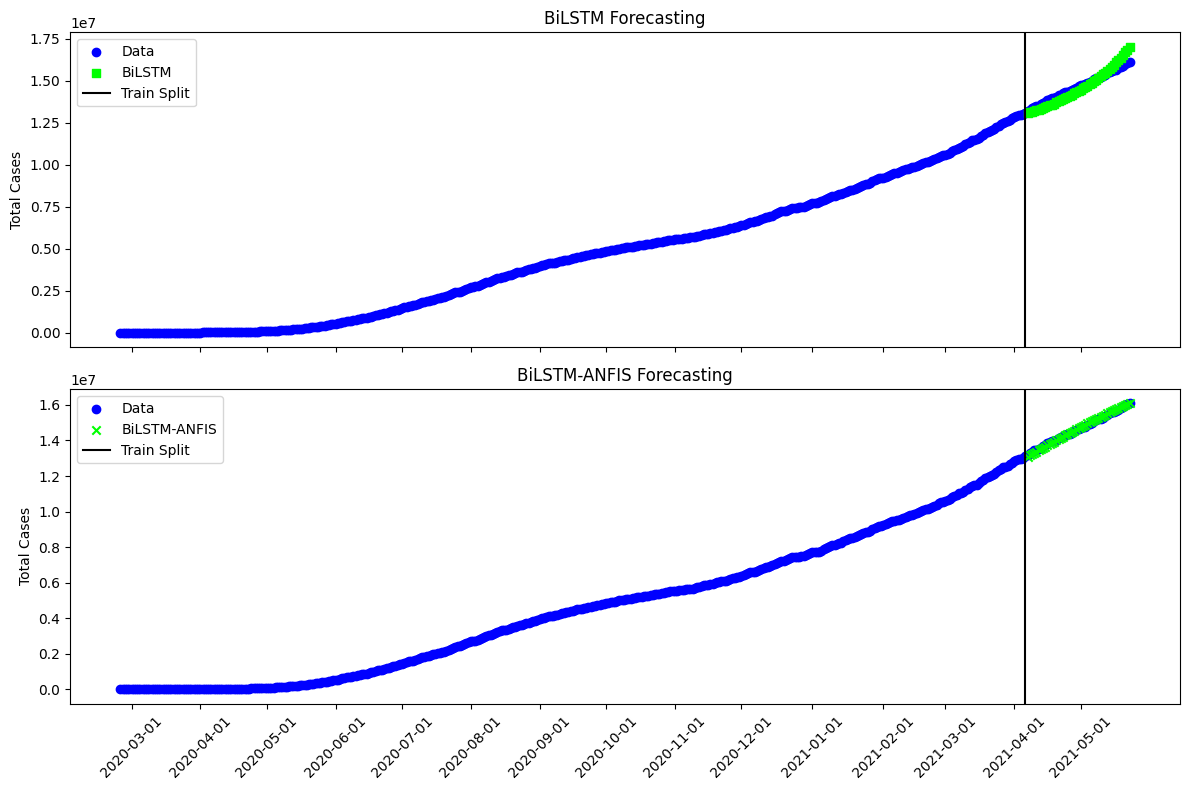

In [11]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

ax[0].scatter(days, cases, label='Data', color='blue')
ax[0].scatter(days_test, test_predictions_bilstm, label='BiLSTM', color='lime', marker='s')
ax[0].axvline(days_train.max(), linestyle='-', color='black', label='Train Split')
ax[0].set_xticks(ticks=tick_indices, labels=tick_labels, rotation=45)
ax[0].set_ylabel('Total Cases')
ax[0].set_title('BiLSTM Forecasting')
ax[0].legend()

ax[1].scatter(days, cases, label='Data', color='blue')
ax[1].scatter(days_test, test_predictions_bilstmanfis, label='BiLSTM-ANFIS', color='lime', marker='x')
ax[1].axvline(days_train.max(), linestyle='-', color='black', label='Train Split')
ax[1].set_xticks(ticks=tick_indices, labels=tick_labels, rotation=45)
ax[1].set_ylabel('Total Cases')
ax[1].set_title('BiLSTM-ANFIS Forecasting')
ax[1].legend()

plt.tight_layout()
plt.show()

In [12]:
rmse_bilstm = np.sqrt(np.mean((cases_test_denorm - test_predictions_bilstm)**2)).item()
rmse_bilstmanfis = np.sqrt(np.mean((cases_test_denorm - test_predictions_bilstmanfis)**2)).item()
mae_bilstm = np.mean(np.abs(cases_test_denorm - test_predictions_bilstm)).item()
mae_bilstmanfis = np.mean(np.abs(cases_test_denorm - test_predictions_bilstmanfis)).item()
mape_bilstm = 100 * np.mean(np.abs((cases_test_denorm - test_predictions_bilstm) / cases_test_denorm)).item()
mape_bilstmanfis = 100 * np.mean(np.abs((cases_test_denorm - test_predictions_bilstmanfis) / cases_test_denorm)).item()

print(f'BiLSTM       | RMSE: {int(rmse_bilstm)} | MAE: {int(mae_bilstm)} | MAPE: {mape_bilstm:.2f}% | Parameters: {params_bilstm}')
print(f'BiLSTM-ANFIS | RMSE: {int(rmse_bilstmanfis)}  | MAE: {int(mae_bilstmanfis)}  | MAPE: {mape_bilstmanfis:.2f}% | Parameters: {params_bilstmanfis}')

BiLSTM       | RMSE: 352969 | MAE: 300692 | MAPE: 2.04% | Parameters: 116264
BiLSTM-ANFIS | RMSE: 79405  | MAE: 70055  | MAPE: 0.49% | Parameters: 505
